In [1]:
import datetime
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt   # plots/gráficos
import matplotlib.dates as mdates

import random                     # controle/geracao de numeros aleatorios
from statistics import mean       # media simples

# imports do sklearn
# metodologia experimental - divisão do dataset em subsets, e avaliação de performance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# medidas de desempenho e plot de matriz de confusão
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae
# preprocessamento, se necessário, dos atributos
from sklearn import preprocessing
from sklearn import utils
import seaborn as sns


In [2]:
# seed para reprodução dos experimentos
seed = 42
random.seed(seed)
np.random.seed(seed)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = '/content/drive/MyDrive/CSV/BrentOilPrices.csv'
brent = pd.read_csv(path)

path2 = '/content/drive/MyDrive/CSV/b3_stocks_1994_2020.csv'
bov = pd.read_csv(path2)

path3 = '/content/drive/MyDrive/CSV/selic.csv'
selic = pd.read_csv(path3)

In [5]:
bov['ticker'] = bov['ticker'].str.replace(' ','')

In [6]:
brent['Date'] = pd.to_datetime(brent.Date)

In [7]:
brent.rename({'Date' : 'datetime'} , axis='columns', inplace='True')
brent.rename({'Price' : 'Brent'} , axis='columns', inplace='True')

In [8]:
petro = bov[bov['ticker'] == 'PETR4']

In [9]:
df_aux = petro.merge(selic, on='datetime')
df_aux['datetime'] = df_aux['datetime'].astype('datetime64[ns]')
brent['datetime'] = brent['datetime'].astype('datetime64[ns]')
df_all = df_aux.merge(brent, on='datetime')
df_all.reset_index()

,index,datetime,ticker,open,close,high,low,volume,selic,Brent
0,0,1998-03-16,PETR4,276.00,275.00,276.00,273.99,2.707893e+07,0.000969,11.74
1,1,1998-03-17,PETR4,275.00,277.00,278.00,274.50,4.104903e+07,0.000965,11.05
2,2,1998-03-18,PETR4,277.00,275.50,279.00,275.00,4.050641e+07,0.000965,12.21
3,3,1998-03-19,PETR4,275.50,275.50,277.00,272.00,2.980126e+07,0.000959,12.41
4,4,1998-03-20,PETR4,277.00,279.00,280.00,276.00,2.671342e+07,0.000963,12.35
...,...,...,...,...,...,...,...,...,...,...
5536,5536,2020-12-22,PETR4,27.20,27.28,27.47,27.05,1.268321e+09,0.000075,49.88
5537,5537,2020-12-23,PETR4,27.43,27.95,28.25,27.35,1.368939e+09,0.000075,51.05
5538,5538,2020-12-28,PETR4,28.36,28.18,28.52,28.18,1.027841e+09,0.000075,50.88
5539,5539,2020-12-29,PETR4,28.38,28.27,28.43,27.99,8.433475e+08,0.000075,50.44


In [10]:
df_all.head()

,datetime,ticker,open,close,high,low,volume,selic,Brent
0,1998-03-16,PETR4,276.0,275.0,276.0,273.99,27078933.9,0.000969,11.74
1,1998-03-17,PETR4,275.0,277.0,278.0,274.50,41049029.3,0.000965,11.05
2,1998-03-18,PETR4,277.0,275.5,279.0,275.00,40506405.9,0.000965,12.21
3,1998-03-19,PETR4,275.5,275.5,277.0,272.00,29801256.4,0.000959,12.41
4,1998-03-20,PETR4,277.0,279.0,280.0,276.00,26713421.3,0.000963,12.35


# Selecionando os dados para aplicação de LSTM univariável

In [11]:
df_univar = df_all[['datetime', 'close']]

In [12]:
df_univar.head()

,datetime,close
0,1998-03-16,275.0
1,1998-03-17,277.0
2,1998-03-18,275.5
3,1998-03-19,275.5
4,1998-03-20,279.0


In [13]:
df_univar.isna().sum()

datetime    0
close       0
dtype: int64

# Selecionando apenas os dados mais recentes

In [14]:
data = df_univar[(df_univar['datetime'] > '2014-01-01')]

In [15]:
data.head()

,datetime,close
3832,2014-01-02,16.75
3833,2014-01-03,16.42
3834,2014-01-06,16.62
3835,2014-01-07,16.16
3836,2014-01-08,16.19


In [16]:
new_data = data

In [17]:
new_data.index = new_data.datetime
new_data.drop('datetime', axis=1, inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [18]:
new_data

,close
datetime,
2014-01-02,16.75
2014-01-03,16.42
2014-01-06,16.62
2014-01-07,16.16
2014-01-08,16.19
...,...
2020-12-22,27.28
2020-12-23,27.95
2020-12-28,28.18


In [19]:
plot_brent = brent[(brent['datetime'] > '2016-01-01')]
plot_brent.index = plot_brent.datetime
plot_brent.drop('datetime', axis=1, inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Text(0.5, 0, 'Data')

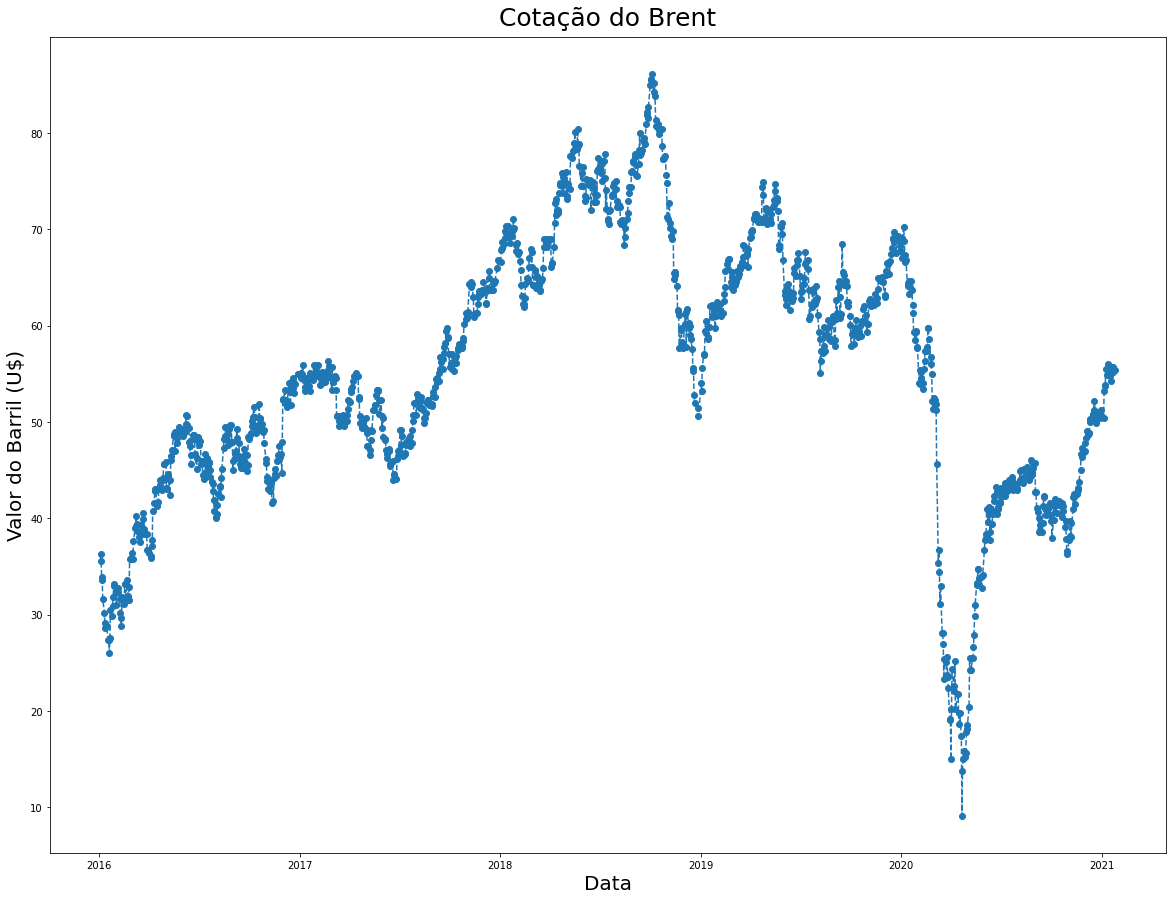

In [20]:
plt.figure(figsize=(20,15))
plt.rcParams['axes.labelsize'] = 20
plt.plot(plot_brent, marker='o', linestyle="--")
plt.title('Cotação do Brent', fontdict={'fontsize':25}, pad=12);
plt.ylabel("Valor do Barril (U$)")
plt.xlabel("Data")

Text(0.5, 0, 'Data')

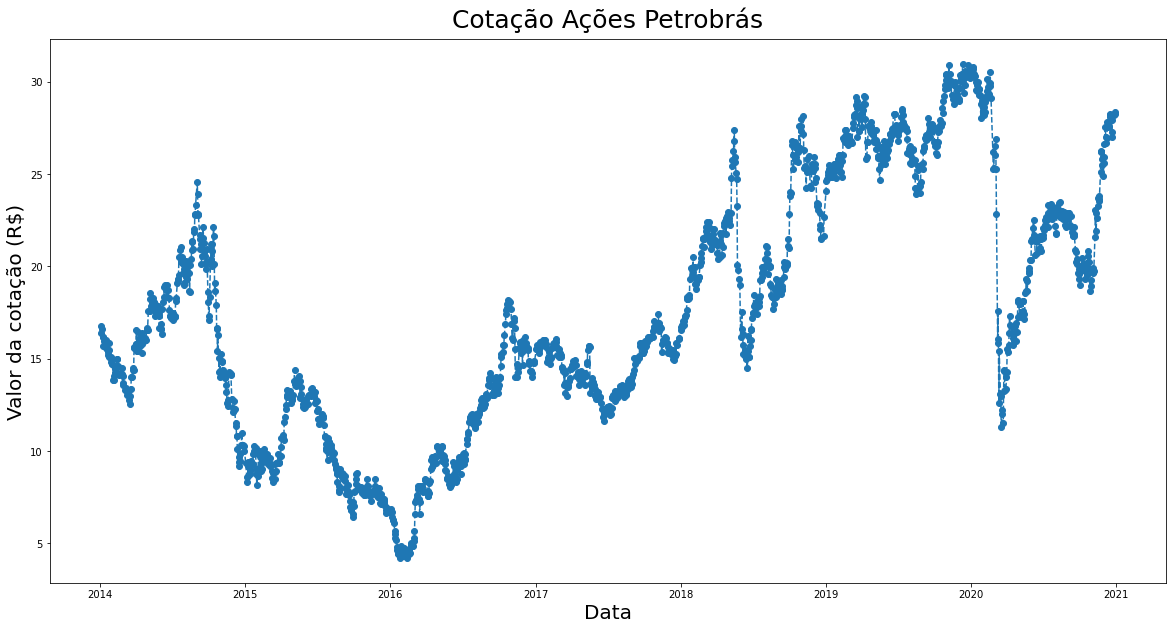

In [21]:
plt.figure(figsize=(20,10))
plt.plot(new_data, marker='o', linestyle="--")
plt.title('Cotação Ações Petrobrás', fontdict={'fontsize':25}, pad=12);
plt.ylabel("Valor da cotação (R$)")
plt.xlabel("Data")

In [22]:
df1=data.reset_index()['close']

In [23]:
df1

0       16.75
1       16.42
2       16.62
3       16.16
4       16.19
        ...  
1704    27.28
1705    27.95
1706    28.18
1707    28.27
1708    28.34
Name: close, Length: 1709, dtype: float64

In [24]:
scaler_uni=MinMaxScaler(feature_range=(0,1))
df1=scaler_uni.fit_transform(np.array(df1).reshape(-1,1))

Separando conjunto de treino e teste

In [25]:
training_size=int(len(df1)*0.75)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [26]:
training_size,test_size

(1281, 428)

Convertendo o vetore de valores em um dataset matriz

In [27]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [28]:
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [29]:
print(X_train.shape), print(y_train.shape)

(1220, 60)
(1220,)


(None, None)

Reajustando para aplicação do LSTM

In [30]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

In [32]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(60,1)))
model.add(Dropout(rate = 0.2))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(loss='mean_squared_error', 
              optimizer='adam', 
              metrics=["MeanSquaredError", "RootMeanSquaredError", "MeanAbsoluteError"]
) 

In [35]:
history = model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=60,verbose=1)

Epoch 1/100
21/21 [==============================] - 10s 191ms/step - loss: 0.0354 - mean_squared_error: 0.0354 - root_mean_squared_error: 0.1882 - mean_absolute_error: 0.1376 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_root_mean_squared_error: 0.1047 - val_mean_absolute_error: 0.0741
Epoch 2/100
21/21 [==============================] - 3s 124ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - root_mean_squared_error: 0.0807 - mean_absolute_error: 0.0636 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_root_mean_squared_error: 0.1120 - val_mean_absolute_error: 0.0700
Epoch 3/100
21/21 [==============================] - 2s 119ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - root_mean_squared_error: 0.0678 - mean_absolute_error: 0.0502 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_root_mean_squared_error: 0.0976 - val_mean_absolute_error: 0.0684
Epoch 4/100
21/21 [==============================] - 2s 117ms/step - loss: 0.0033 - mean_squared_error

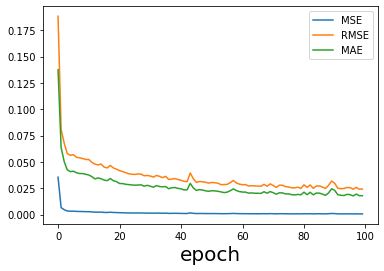

In [36]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['mean_absolute_error'])
plt.xlabel('epoch')
plt.legend(['MSE', 'RMSE', 'MAE'], loc='upper right')
plt.show()

In [37]:
import tensorflow as tf

Fazendo as predições

In [38]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

12/12 [==============================] - 0s 24ms/step


Retornando os valores às escalas normais

In [39]:
train_predict=scaler_uni.inverse_transform(train_predict)
test_predict=scaler_uni.inverse_transform(test_predict)
ytest = scaler_uni.inverse_transform(ytest.reshape(-1,1))

Calculando as métricas de performance

In [40]:
MES_uni = mean_squared_error(ytest,test_predict)
print(MES_uni)

0.6827468302672679


In [41]:
MAE_uni = mae(ytest, test_predict)
print(MAE_uni)

0.5676693120639396


In [42]:
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(train_predict)+time_step, :] = train_predict

In [43]:
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(time_step*2)+1:len(df1)-1, :] = test_predict

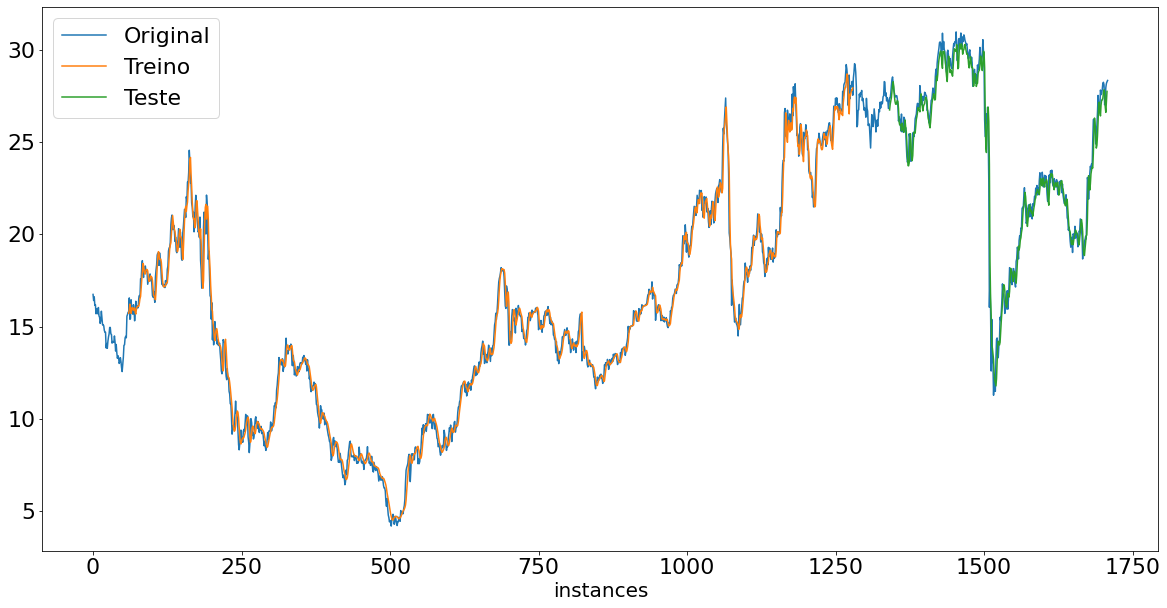

In [44]:
#Visualizando a Previsão
plt.rcParams.update({'font.size': 22})


plt.figure(figsize=(20,10))
plt.plot(scaler_uni.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlabel('instances')
plt.legend(['Original', 'Treino', 'Teste'], loc='upper left')
plt.show()

# Aplicando LSTM mutivariável para comparação de eficácia 

In [45]:
df_all = df_all[(df_all['datetime'] > '2014-01-01')]
df_all.drop('ticker',axis='columns', inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [46]:
df_all.head()

,datetime,open,close,high,low,volume,selic,Brent
3832,2014-01-02,17.15,16.75,17.20,16.65,291684421.0,0.000375,107.94
3833,2014-01-03,16.74,16.42,16.78,16.42,295038188.0,0.000375,106.57
3834,2014-01-06,16.45,16.62,16.64,16.16,337127621.0,0.000375,106.71
3835,2014-01-07,16.65,16.16,16.83,16.16,314019662.0,0.000375,107.01
3836,2014-01-08,16.27,16.19,16.39,16.15,258052487.0,0.000375,107.42


In [47]:
day = df_all['datetime']
df_all.drop('datetime',axis='columns', inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [48]:
# List of considered Features
FEATURES = ['high', 'low', 'open', 'close', 'volume', 'selic', 'Brent']

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(df_all)
data_filtered = data[FEATURES]

# Print the tail of the dataframe
data_filtered.tail()

FEATURE LIST
['high', 'low', 'open', 'close', 'volume', 'selic', 'Brent']


,high,low,open,close,volume,selic,Brent
5536,27.47,27.05,27.20,27.28,1.268321e+09,0.000075,49.88
5537,28.25,27.35,27.43,27.95,1.368939e+09,0.000075,51.05
5538,28.52,28.18,28.36,28.18,1.027841e+09,0.000075,50.88
5539,28.43,27.99,28.38,28.27,8.433475e+08,0.000075,50.44
5540,28.49,28.20,28.35,28.34,1.047992e+09,0.000075,50.74


In [49]:
import seaborn as sns

In [50]:
data_filtered.corr()

,high,low,open,close,volume,selic,Brent
high,1.000000,0.998686,0.999210,0.999002,0.616273,-0.774588,0.272697
low,0.998686,1.000000,0.998923,0.999152,0.587968,-0.770878,0.272004
open,0.999210,0.998923,1.000000,0.998075,0.603567,-0.772497,0.271892
close,0.999002,0.999152,0.998075,1.000000,0.600940,-0.772819,0.272457
volume,0.616273,0.587968,0.603567,0.600940,1.000000,-0.584829,-0.005208
selic,-0.774588,-0.770878,-0.772497,-0.772819,-0.584829,1.000000,0.023773
Brent,0.272697,0.272004,0.271892,0.272457,-0.005208,0.023773,1.000000


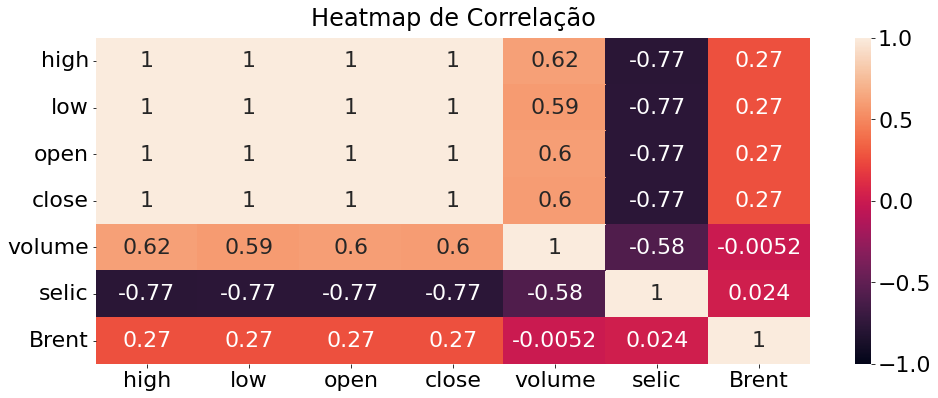

In [51]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(data_filtered.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Heatmap de Correlação', fontdict={'fontsize':24}, pad=12);

In [52]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler(feature_range=(0,1))
df_Close = pd.DataFrame(data_filtered['close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(1709, 7)


In [53]:
# Prediction Index
index_Close = data.columns.get_loc("close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 75% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.75)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len:len(np_data_scaled), :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(time_step, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(time_step, data_len):
        x.append(data[i-time_step:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(time_step, train_data)
x_test, y_test = partition_dataset(time_step, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][time_step-1][index_Close])
print(y_train[0])

(1222, 60, 7) (1222,)
(367, 60, 7) (367,)
0.43062926459438977
0.43062926459438977


In [54]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(rate = 0.2))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [55]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 50)            11600     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 60, 50)            20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 52,051
Trainable params: 52,051
Non-trainable params: 0
_________________________________________________________________


In [56]:
model.compile(loss='mean_squared_error', 
              optimizer='adam', 
              metrics=["MeanSquaredError", "RootMeanSquaredError", "MeanAbsoluteError"]
) 

In [ ]:
history = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=60,verbose=1)

Epoch 1/100
21/21 [==============================] - 10s 185ms/step - loss: 0.0263 - mean_squared_error: 0.0263 - root_mean_squared_error: 0.1623 - mean_absolute_error: 0.1180 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_root_mean_squared_error: 0.1286 - val_mean_absolute_error: 0.1015
Epoch 2/100
21/21 [==============================] - 3s 119ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - root_mean_squared_error: 0.0729 - mean_absolute_error: 0.0552 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_root_mean_squared_error: 0.1065 - val_mean_absolute_error: 0.0738
Epoch 3/100
21/21 [==============================] - 2s 118ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - root_mean_squared_error: 0.0600 - mean_absolute_error: 0.0433 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_root_mean_squared_error: 0.1022 - val_mean_absolute_error: 0.0669
Epoch 4/100
21/21 [==============================] - 3s 123ms/step - loss: 0.0032 - mean_squared_error

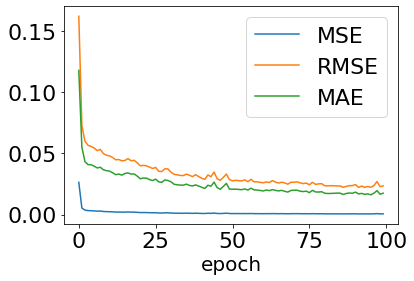

In [ ]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['mean_absolute_error'])
plt.xlabel('epoch')
plt.legend(['MSE', 'RMSE', 'MAE'], loc='upper right')
plt.show()

# Realizando as predições

In [ ]:
train_predict_mult=model.predict(x_train)
test_predict_mult=model.predict(x_test)

12/12 [==============================] - 0s 25ms/step


**Retornando valores à escala normal**

In [ ]:
test_unscaledmult = scaler_pred.inverse_transform(test_predict_mult)
train_unscaledmult = scaler_pred.inverse_transform(train_predict_mult)
y_test = scaler_pred.inverse_transform(y_test.reshape(-1,1))

**Calculando as métricas de avaliação**

In [ ]:
MSE_multi = mean_squared_error(y_test,test_unscaledmult)
print(MSE_multi)

0.6832378431019019


In [ ]:
MAE_mult = mae(y_test, test_unscaledmult)
print(MAE_mult)

0.5290936589715184


**Plotando resultados**

In [ ]:
df1=data.reset_index()['close']
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(train_unscaledmult)+time_step, :] = train_unscaledmult

In [ ]:
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_unscaledmult)+((time_step*2)-2)+1:len(df1)-1, :] = test_unscaledmult

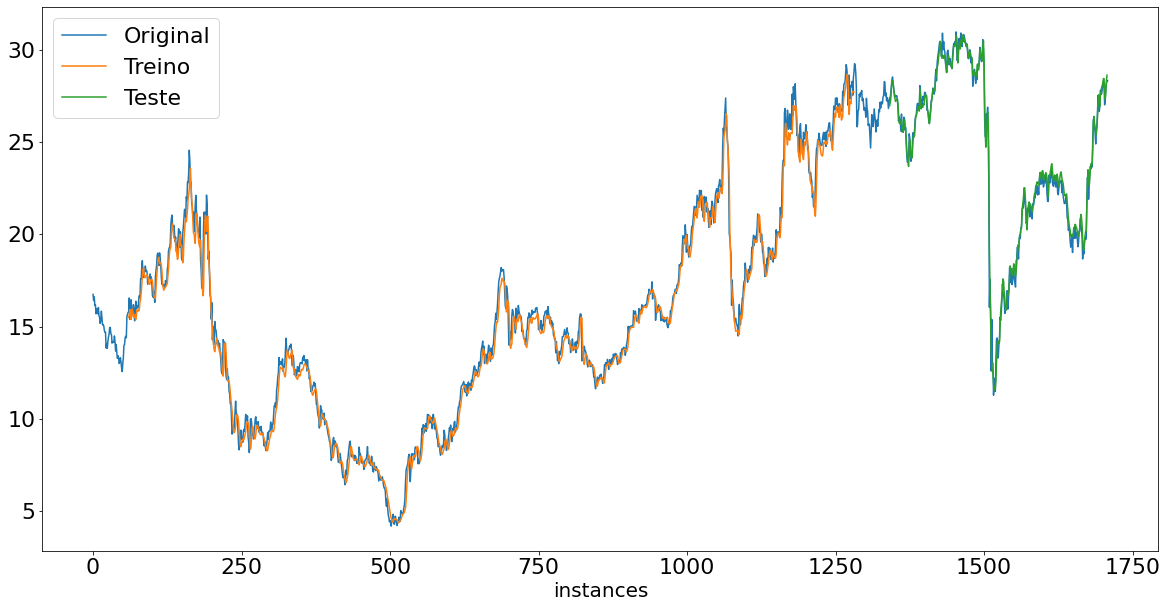

In [ ]:
#Visualizando a Previsão
plt.rcParams.update({'font.size': 22})


plt.figure(figsize=(20,10))
plt.plot(scaler_uni.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlabel('instances')
plt.legend(['Original', 'Treino', 'Teste'], loc='upper left')
plt.show()